In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)


import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = (15, 20)

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler, RobustScaler, Normalizer

from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold

from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.linear_model import SGDOneClassSVM

import math
import scipy.stats as ss

In [76]:
#Reading Files
path = "/Users/larst/OneDrive/Documents/GitHub/KaggleS3E21/data/"
data = pd.read_csv(path+"sample_submission.csv")
newdata1 = pd.read_csv(path+"train.csv")
sub = pd.read_csv(path+"bs.csv")
newdata1.dropna(inplace=True)
newdata1.rename(columns={"Id": "id"},inplace=True)
for i in range(len(newdata1)):
    newdata1["id"].iloc[i]=10000+i

C:\Users\larst\AppData\Local\Temp\ipykernel_26740\2009263014.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newdata1["id"].iloc[i]=10000+i
C:\Users\larst\AppData\Local\Temp\ipykernel_26740\2009263014.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newdata1["id"].iloc[i]=10000+i
C:\Users\larst\AppData\Local\Temp\ipykernel_26740\2009263014.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newdata1["id"].iloc[i]=10000+i
C:\User

In [3]:
rf = RandomForestRegressor(
       n_estimators=1000,
       max_depth=7,
       n_jobs=-1,
       random_state=42)



In [9]:
train_data = data[(data.target>30)]
remaining_data = data[data.target<=30]

X_train, X_test, y_train, y_test = train_test_split(remaining_data.drop(['target'], axis = 1),remaining_data.loc[:,'target'],test_size=700,random_state=42)
data_train = pd.concat([X_train,y_train],axis=1)
data_train = pd.concat([data_train,train_data],axis=0)
X_train = data_train.drop(['target'], axis = 1)
y_train = data_train.loc[:,'target']


print(X_train.shape)
print(X_test.shape)



(2818, 36)
(700, 36)


<Axes: xlabel='id', ylabel='target'>

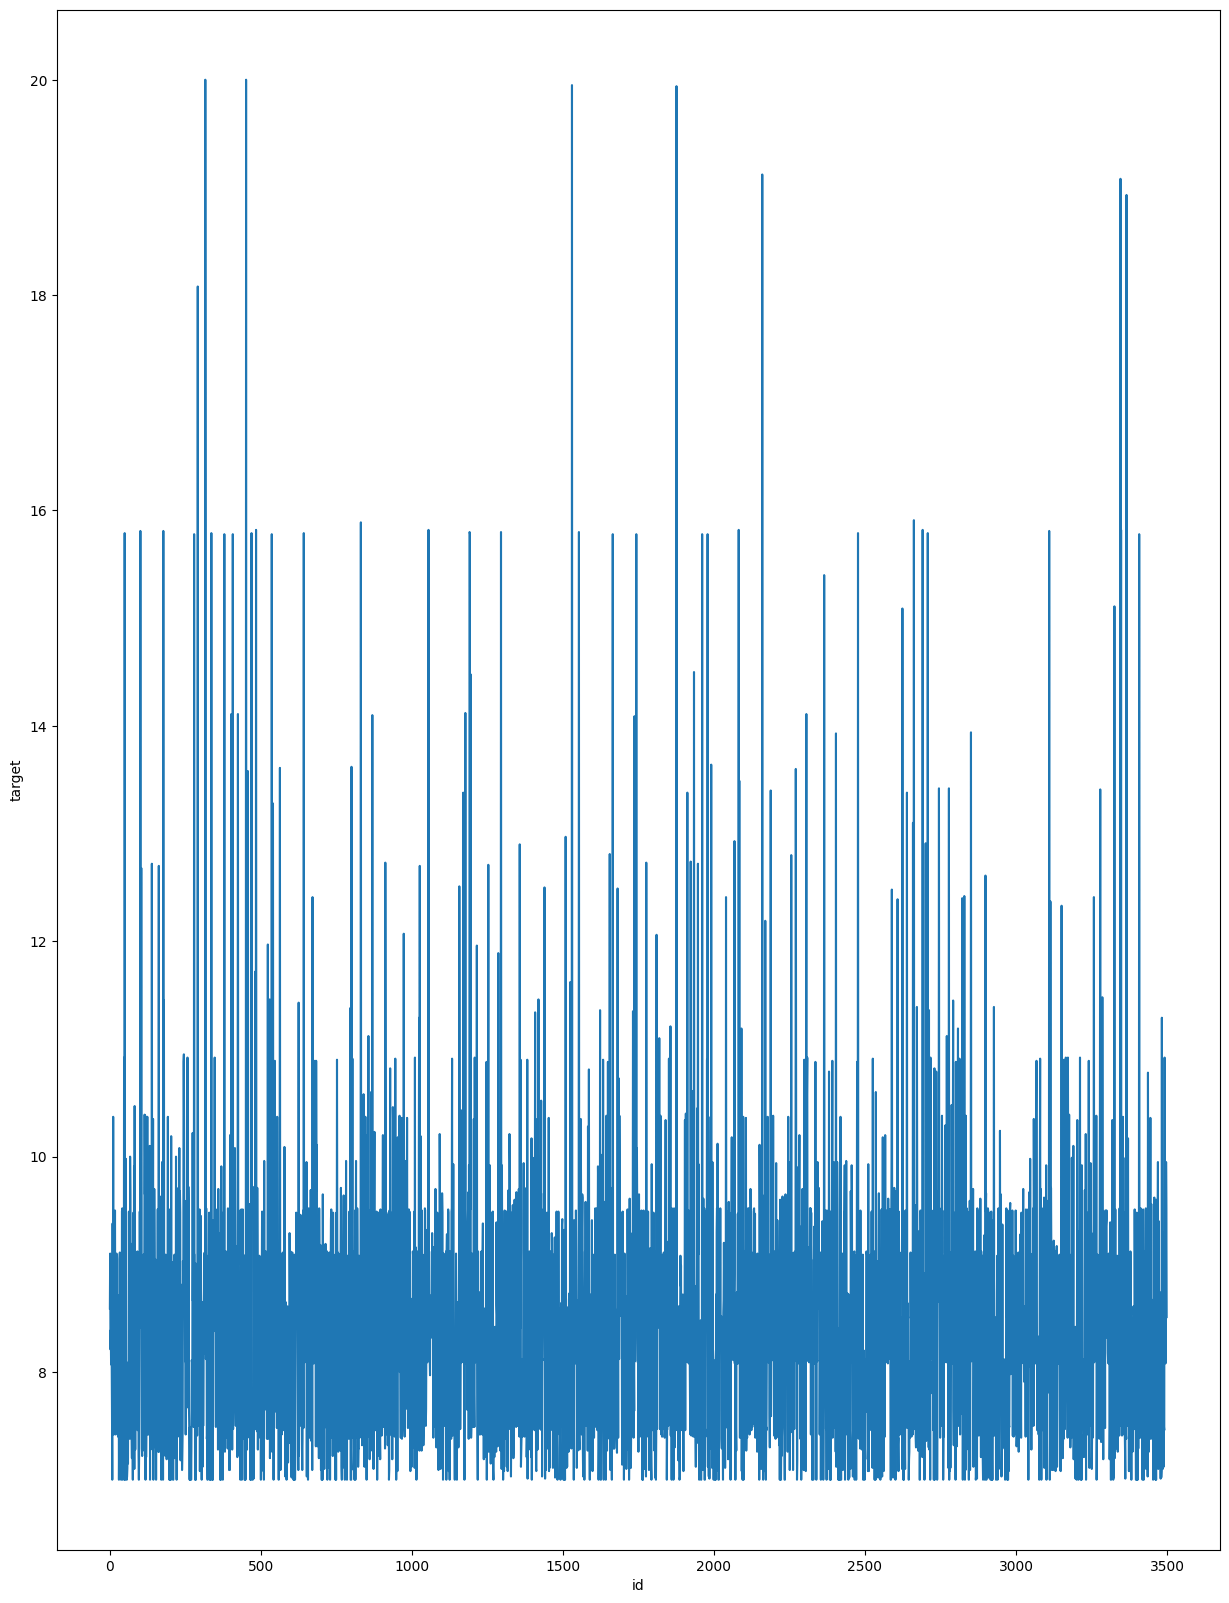

In [79]:
#clipping
data.target = data.target.clip(lower = 7, upper = 20)
sns.lineplot(data=data, x='id',y='target')


<Axes: xlabel='id', ylabel='target'>

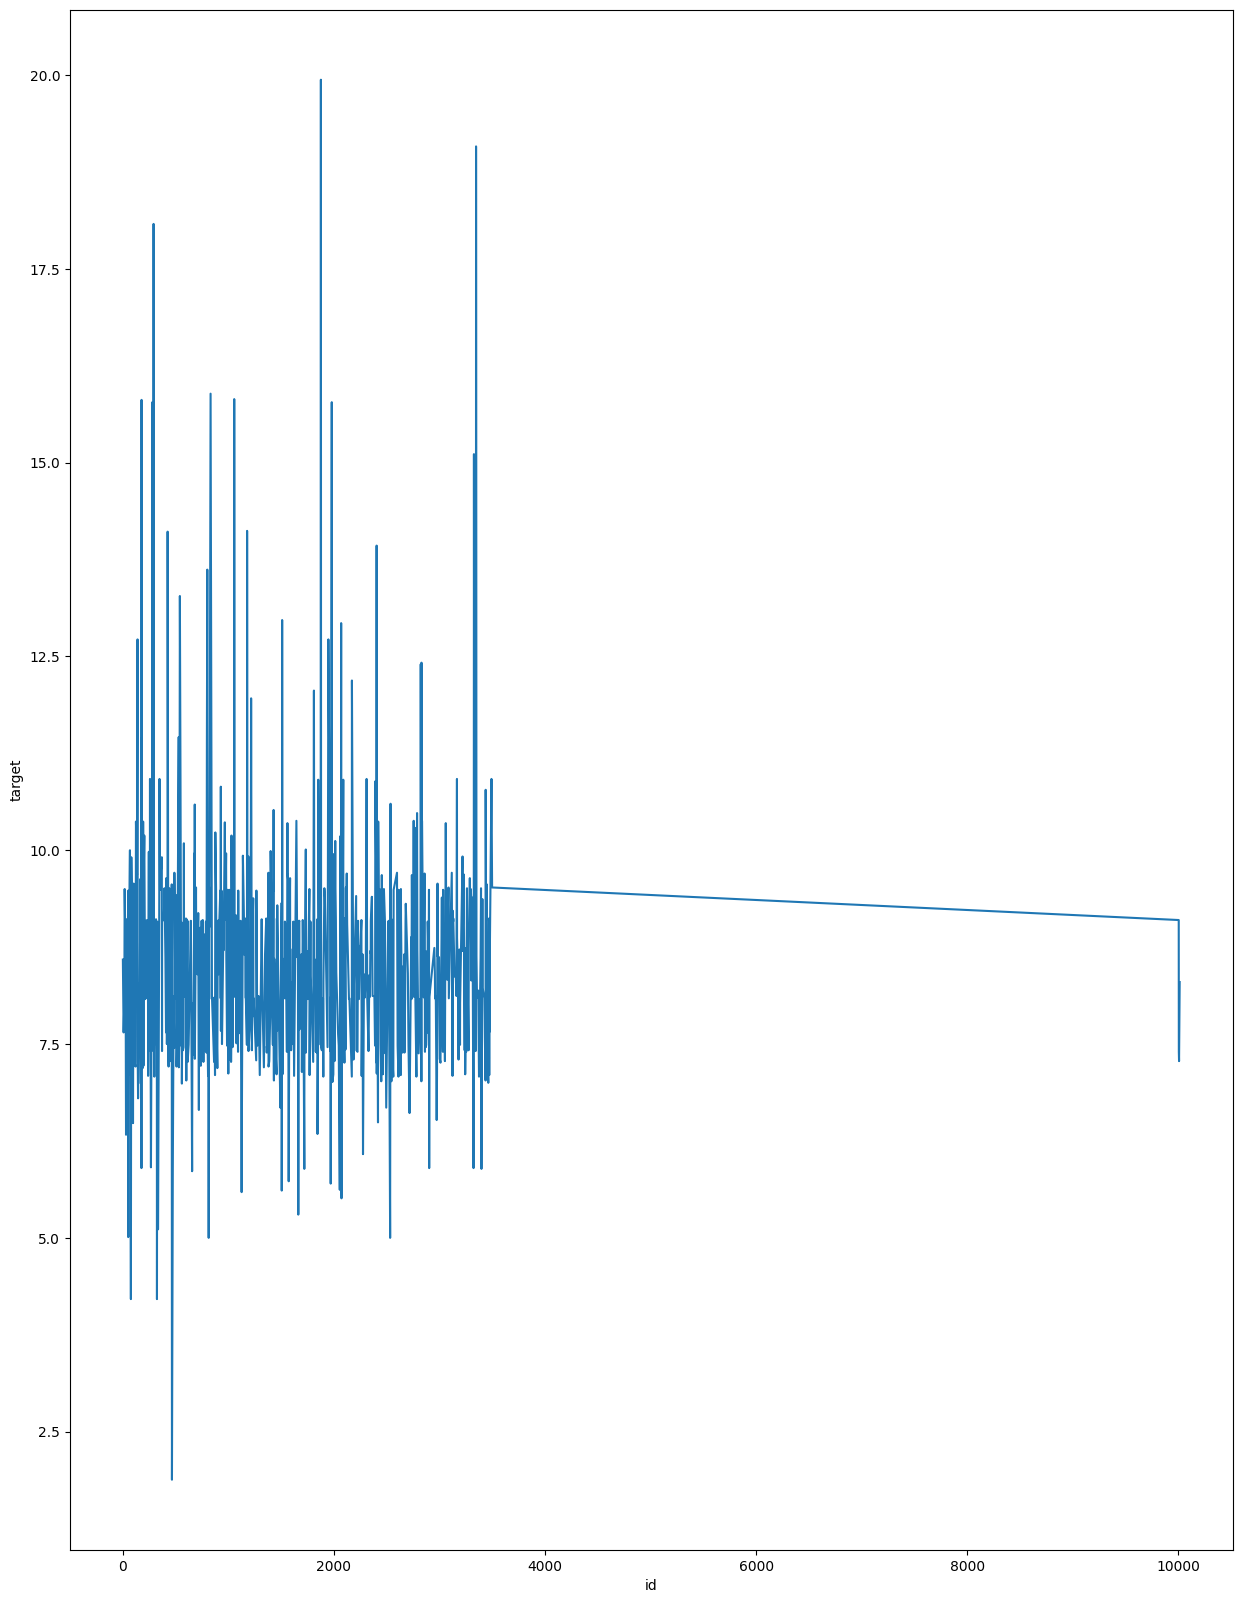

In [12]:


sns.lineplot(data=pd.concat([X_test,y_test],axis=1), x='id',y='target')



In [13]:
X = data.drop(['id','target'],axis=1)
y = data.loc[:,'target']
rf = RandomForestRegressor(
       n_estimators=1000,
       max_depth=7,
       n_jobs=-1,
       random_state=42)
rf.fit(X,y)
importances = rf.feature_importances_
columns = X.columns
importance_dict = dict()
for i in range(len(columns)):
    importance_dict[columns[i]] = importances[i]
importance_desc = dict(sorted(importance_dict.items(), key = lambda x:x[1], reverse=True))
importance_asc = dict(sorted(importance_dict.items(), key = lambda x:x[1], reverse=False))
print(importance_desc)



{'O2_1': 0.7227890208122844, 'O2_2': 0.047795281874001484, 'NH4_1': 0.01583398096279593, 'NO2_2': 0.01321031624911524, 'NO3_6': 0.013131332828975559, 'O2_4': 0.011658532591914746, 'O2_5': 0.009397745750412254, 'O2_7': 0.008609160842343455, 'NH4_2': 0.008554319356105573, 'BOD5_3': 0.008421862060281447, 'BOD5_6': 0.008239130734933896, 'O2_6': 0.008071270391560532, 'NO2_1': 0.008043822034415594, 'NO2_6': 0.0076898141282735885, 'NH4_4': 0.007356426085380929, 'NH4_3': 0.0068278824491531, 'NO3_7': 0.006436778273759667, 'BOD5_1': 0.006259263172147212, 'NO2_3': 0.006241763752979587, 'BOD5_2': 0.006049987627710415, 'BOD5_5': 0.006040695813615116, 'NH4_6': 0.005507703168130839, 'NO3_2': 0.005477039165578851, 'NH4_5': 0.005241355886529538, 'NO2_7': 0.004941398181238454, 'NO3_3': 0.004907883791326877, 'BOD5_4': 0.004543923117631495, 'O2_3': 0.0045064593023764875, 'NO3_5': 0.004407659015420475, 'BOD5_7': 0.004398621299285661, 'NO2_4': 0.004263708173456845, 'NO2_5': 0.004218072656234383, 'NO3_4': 0.

In [14]:
svm = SGDOneClassSVM(nu=0.1).fit(data.drop(['id'],axis=1))
data['svm_anomaly'] = svm.predict(data.drop(['id'],axis=1))
len(np.where(data['svm_anomaly']==-1)[0])



5

In [15]:
If = IsolationForest(contamination=0.005).fit(data.drop(['id','svm_anomaly'],axis=1))
data['if_anomaly'] = If.predict(data.drop(['id','svm_anomaly'],axis=1))
len(np.where(data['if_anomaly']==-1)[0])

18

In [16]:
lof = LocalOutlierFactor(contamination=0.005)
data['lof_anomaly'] = lof.fit_predict(data.drop(['id','svm_anomaly','if_anomaly'],axis=1))
len(np.where(data['lof_anomaly']==-1)[0])

18

In [24]:
data

,id,target,O2_1,O2_2,O2_3,O2_4,O2_5,O2_6,O2_7,NH4_1,NH4_2,NH4_3,NH4_4,NH4_5,NH4_6,NH4_7,NO2_1,NO2_2,NO2_3,NO2_4,NO2_5,NO2_6,NO2_7,NO3_1,NO3_2,NO3_3,NO3_4,NO3_5,NO3_6,NO3_7,BOD5_1,BOD5_2,BOD5_3,BOD5_4,BOD5_5,BOD5_6,BOD5_7,svm_anomaly,if_anomaly,lof_anomaly
0,0,8.59,7.500,9.00,9.545,9.265,8.110,8.430,7.15,0.180,0.200,0.650,14.515,5.845,1.2850,0.429,0.030,0.050,0.0640,0.7300,1.0750,0.0560,0.567,0.400,1.500,1.560,19.3550,4.95,1.7300,1.800,4.800,3.15,10.665,10.465,16.645,5.750,10.37,1,1,1
1,1,9.10,13.533,40.90,8.770,9.265,6.015,10.070,7.15,1.107,1.027,1.848,8.625,12.175,0.2800,0.440,0.089,1.360,0.0640,0.9020,1.4540,0.0560,0.190,2.347,5.105,2.095,19.3550,20.05,9.5300,7.695,4.550,6.95,2.040,5.200,5.725,2.950,2.23,1,1,1
2,2,8.21,3.710,5.42,8.770,9.265,4.550,10.070,7.15,0.020,0.020,0.650,17.144,24.645,0.3800,0.440,0.060,0.050,0.0820,0.9020,2.0250,0.0560,0.567,1.700,1.700,3.960,4.9000,4.58,3.0250,3.960,4.935,4.95,4.725,6.075,6.750,3.500,3.17,1,1,1
3,3,8.39,8.700,8.10,9.500,9.200,5.200,8.670,6.67,0.280,0.270,1.730,3.870,8.410,1.4800,1.380,0.050,0.050,0.0700,0.5300,1.7400,0.0500,0.064,1.500,1.500,2.020,3.9600,8.45,2.0700,1.730,6.300,4.70,3.500,6.200,8.670,2.900,7.37,1,1,1
4,4,8.07,8.050,8.65,7.960,9.265,3.290,10.070,7.15,0.360,0.435,0.650,3.850,5.845,0.2800,0.440,0.105,0.115,0.0740,1.2520,1.0750,0.0710,0.190,1.050,1.150,2.095,3.9020,2.02,1.7300,0.760,4.800,4.97,3.950,2.800,8.400,3.500,3.90,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127,10013,8.72,8.100,8.30,4.660,7.700,3.240,10.230,7.01,0.215,0.180,2.740,4.190,5.200,0.3600,0.530,0.070,0.105,0.0840,0.5500,1.2300,0.0180,0.017,1.600,2.205,2.200,10.9800,8.45,2.2100,1.840,4.600,4.90,2.210,14.790,27.120,3.490,1.83,1,1,1
131,10014,14.10,11.000,8.60,9.290,7.260,0.600,9.240,4.17,0.180,0.200,0.610,17.590,24.320,0.3500,0.980,0.050,0.040,0.7200,0.5300,0.4500,0.0200,0.099,1.900,3.000,2.300,2.8300,0.67,0.4400,1.730,10.400,8.00,4.100,5.000,9.250,2.400,4.45,1,1,1
133,10015,8.10,7.500,8.50,9.000,7.600,3.290,8.430,2.31,0.300,0.300,1.640,0.515,16.645,1.2850,0.429,0.012,0.080,0.1345,0.9025,1.4545,0.0565,0.567,0.400,0.550,2.095,4.9005,2.02,0.6365,1.800,5.000,5.40,10.665,10.465,8.415,6.625,8.25,1,1,1
137,10016,9.50,9.700,8.90,9.545,8.370,6.025,9.805,5.03,1.490,2.600,1.848,10.090,14.515,0.3805,0.844,0.065,0.095,0.0735,1.2520,0.7460,0.0370,0.071,3.290,4.220,3.960,14.7750,4.58,1.7300,0.760,2.520,1.72,4.725,6.075,5.725,2.950,7.37,1,1,1


In [31]:
lowest_quality_labels = [3366, 2365,  465, 1776, 1295,  800, 2306,  402, 1215, 1737, 3212,  529,  482, 2068, 1163, 1408, 2246, 1681, 162]


rows_to_remove = np.union1d(np.union1d(np.union1d(np.where(data['svm_anomaly']==-1),np.where(data['if_anomaly']==-1)),np.where(data['lof_anomaly']==-1)),lowest_quality_labels)



In [39]:
data_dropped = data[~data["id"].isin(rows_to_remove)]
data_dropped.shape
data_dropped['target']=data_dropped['target'].clip(7,20)

(3460, 40)

In [51]:
def get_mse(data,bot_cutoff,top_cutoff,n_column,nu,contamination_if,contamination_lof,n_lowest_quality):
    np.random.seed(42)
    
    fixed_train_indexes = [316,451]
    
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    
    total_mse = 0
    for train_index, test_index in kf.split(data):
        for idx in fixed_train_indexes:
            if idx not in train_index:
                train_index = np.append(train_index,np.array([idx]))
        train_data = data[data.index.isin(train_index)]
        test_data = data[data.index.isin(test_index)]
    
        X_train = train_data.drop('target',axis=1)
        y_train = train_data.loc[:,'target']
        X_test = test_data.drop('target',axis=1)
        y_test = test_data.loc[:,'target']

        #Removing the lowest quality labels
        for row in lowest_quality_labels[:n_lowest_quality]:
            if row in X_train.index:
                X_train.drop(row,axis=0,inplace=True)
                y_train.drop(row,axis=0,inplace=True)

        X_train = X_train.reset_index(drop=True)
        y_train = y_train.reset_index(drop=True)

        # Clipping
        y_train = y_train.clip(bot_cutoff,top_cutoff)

        # Single Class SVM for outlier removal
        if nu!=0:
            svm = SGDOneClassSVM(nu=nu, random_state=42)
            svm.fit(pd.concat([X_train,y_train],axis=1))
            svm_pred = svm.predict(pd.concat([X_train,y_train],axis=1))
            svm_anomalies = np.where(svm_pred==-1)
        else:
            svm_anomalies = []

        #Isolation Forest for outlier removal
        if contamination_if!=0:
            If = IsolationForest(contamination = contamination_if, random_state=42)
            If.fit(pd.concat([X_train,y_train],axis=1))
            if_pred = If.predict(pd.concat([X_train,y_train],axis=1))
            if_anomalies = np.where(if_pred==-1)
        else:
            if_anomalies = []

        # Feature Removal
        non_zero_columns = list(importance_desc.keys())[:n_column]
        for column in X_train.columns:
            if column not in non_zero_columns:
                X_train[column] = 0

        # Local Outlier Factor for outlier removal
        if contamination_lof!=0:
            lof = LocalOutlierFactor(n_neighbors=3,contamination=contamination_lof)
            lof.fit(pd.concat([X_train,y_train],axis=1))
            lof_pred = lof.fit_predict(pd.concat([X_train,y_train],axis=1))
            lof_anomalies = np.where(lof_pred==-1)
        else:
            lof_anomalies = []

        # Removing the rows which any of the anomaly detectors say is an anomaly
        rows_to_remove = np.union1d(np.union1d(if_anomalies,svm_anomalies),lof_anomalies)
        X_train.drop(rows_to_remove,axis=0,inplace=True)
        y_train.drop(rows_to_remove,axis=0,inplace=True)

        # Prediction on test data with the Evaluation Model provided
        rf = RandomForestRegressor(
           n_estimators=1000,
           max_depth=7,
           n_jobs=-1,
           random_state=42
        )
        rf.fit(X_train,y_train)
        y_hat = rf.predict(X_test)
        mse = (mean_squared_error(y_test,y_hat))**0.5
        total_mse += mse
        
    return total_mse/5

In [53]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error

data = data_dropped.copy()
min_error = 50 # Initializing the error to a very high value
bot_cutoffs = [7]
top_cutoffs = [20,35]
n_columns = [3]
nus= [0.5]
contamination_ifs = [0.005,0.01,0.1]
contamination_lofs = [0.005,0.01,0.1]
n_lowest_qualities = [10]
iteration = 1
for bot_cutoff in bot_cutoffs:
    for top_cutoff in top_cutoffs:
        for n_column in n_columns:
            for nu in nus:
                for contamination_if in contamination_ifs:
                    for contamination_lof in contamination_lofs:
                        for n_lowest_quality in n_lowest_qualities:
                            mse = get_mse(data.drop('id',axis=1),bot_cutoff,top_cutoff,n_column,nu,contamination_if,contamination_lof,n_lowest_quality)
                            if mse < min_error:
                                min_error = mse
                                min_bot_cutoff = bot_cutoff
                                min_top_cutoff = top_cutoff
                                min_n_column = n_column
                                min_nu = nu
                                min_contamination_if = contamination_if
                                min_contamination_lof = contamination_lof
                                min_n_lowest_quality = n_lowest_quality
                                print(f'min_cutoff: {min_bot_cutoff},{min_top_cutoff},{n_column},{nu},{contamination_if},{contamination_lof},{n_lowest_quality} mse:{min_error}')

                            print(f'Iteration {iteration} of {len(bot_cutoffs)*len(top_cutoffs)*len(n_columns)*len(nus)*len(contamination_ifs)*len(contamination_lofs)*len(n_lowest_qualities)}')
                            iteration +=1

min_cutoff: 7,20,3,0.5,0.005,0.005,10 mse:0.8868566073161347
Iteration 1 of 18
Iteration 2 of 18
Iteration 3 of 18
Iteration 4 of 18
Iteration 5 of 18
Iteration 6 of 18
Iteration 7 of 18
Iteration 8 of 18
Iteration 9 of 18
Iteration 10 of 18
Iteration 11 of 18
Iteration 12 of 18
Iteration 13 of 18
Iteration 14 of 18
Iteration 15 of 18
Iteration 16 of 18
Iteration 17 of 18
Iteration 18 of 18


In [55]:
data = pd.read_csv(path+"sample_submission.csv")
data = pd.concat([data,newdata1],ignore_index=False)

np.random.seed(42)

data.drop(lowest_quality_labels[:min_n_lowest_quality],axis=0,inplace=True)
data = data.reset_index(drop=True)

# Clipping target variable
data['target'] = data['target'].clip(min_bot_cutoff,min_top_cutoff)

# Single Class SVM for outlier removal
if min_nu != 0:
    svm = SGDOneClassSVM(nu=min_nu, random_state=42)
    svm.fit(data.drop(['id'],axis=1))
    svm_pred = svm.predict(data.drop(['id'],axis=1))
    svm_anomalies = np.where(svm_pred==-1)
    print(f'Total SVM anomalies detected:{len(svm_anomalies[0])}')
else:
    svm_anomalies = []

#Isolation Forest for outlier removal
if min_contamination_if != 0:
    If = IsolationForest(contamination = min_contamination_if, random_state = 42)
    If.fit(data.drop(['id'],axis=1))
    if_pred = If.predict(data.drop(['id'],axis=1))
    if_anomalies = np.where(if_pred==-1)
    print(f'Total IF anomalies detected:{len(if_anomalies[0])}')
else:
    if_anomalies = []
    
# Feature Removal
non_zero_columns = list(importance_desc.keys())[:min_n_column] + ['target']
for column in data.columns:
    if column not in non_zero_columns:
        data[column] = 0

# Local Outlier Factor for outlier removal
if min_contamination_lof != 0:
    lof = LocalOutlierFactor(n_neighbors=3,contamination=min_contamination_lof)
    lof.fit(data.drop(['id'],axis=1))
    lof_pred = lof.fit_predict(data.drop(['id'],axis=1))
    lof_anomalies = np.where(lof_pred==-1)
    print(f'Total LOF anomalies detected:{len(lof_anomalies[0])}')
else:
    lof_anomalies = []

# Applying all the outlier removal technique and clean learning
rows_to_remove = np.union1d(np.union1d(if_anomalies,svm_anomalies),lof_anomalies)
print(f'Total anomalies detected:{len(rows_to_remove)+min_n_lowest_quality}')
data.drop(rows_to_remove,axis=0,inplace=True)

Total SVM anomalies detected:24
Total IF anomalies detected:18
Total LOF anomalies detected:18
Total anomalies detected:70


In [56]:
data.to_csv('submission.csv',index=False)

In [ ]:
iso = IsolationForest(random_state = 0)
yhat = iso.fit_predict(data_SVM.drop('id', axis = 1))

print('Outliers detected (Isolation Forest): {}'.format(np.count_nonzero(yhat == -1)))

mask = yhat != -1
data_ISO = data_SVM.loc[mask, :].reset_index(drop = True)

X_ISO, Y_ISO = data_ISO.drop("target", axis=1), data_ISO.target

scores = cross_val_score(rf, 
                         X_ISO,
                         Y_ISO,
                         cv = 10, 
                         scoring = 'neg_root_mean_squared_error',
                         n_jobs = -1)

print(f'[{iso.__class__.__name__}] --> RMSE Mean: {scores.mean()}, Standard Deviation: {scores.std()}')

In [ ]:
lof = LocalOutlierFactor(n_neighbors=3, contamination=0.12)
yhat = lof.fit_predict(data_ISO.drop(['id', 'target'], axis = 1))

print('Outliers detected (Local Outlier Factor): {}'.format(np.count_nonzero(yhat == -1)))

mask = yhat != -1
data_final = data_ISO.loc[mask, :].reset_index(drop = True)

X_LOF, Y_LOF = data_final.drop('target', axis = 1), data_final.target

scores = cross_val_score(rf, 
                         X_LOF,
                         Y_LOF,
                         cv = 10, 
                         scoring = 'neg_root_mean_squared_error',
                         n_jobs = -1)

print(f'[{lof.__class__.__name__}] --> RMSE Mean: {scores.mean()}, Standard Deviation: {scores.std()}')

In [59]:
data_final=data.copy()

In [60]:
X_final, y_final = data_final.drop('target', axis = 1), data_final.target



In [61]:
rf.fit(X_final, y_final)

imp = pd.DataFrame({'importances': rf.feature_importances_}, index = X_final.columns).sort_values(by = 'importances', ascending = False)

In [62]:
selected_features = [
    'O2_1', 
    'O2_2',
    'BOD5_5'
    ,'NO2_2'
    ,'O2_4'
    ,'NH4_6'
    ,'NH4_1'
    #,'NH4_5'
    #,'O2_7'
    #,'O2_6'
]

In [63]:
# kf = RepeatedKFold(n_splits = 10, n_repeats = 5, random_state = 0)
scores = cross_val_score(rf, 
                         X_final[selected_features],
                         y_final,
                         cv = 10, 
                         scoring = 'neg_root_mean_squared_error',
                         n_jobs = -1)

print(f'[ENSEMBLE + FS + CLIPPING_7_20] --> RMSE Mean: {scores.mean()}, Standard Deviation: {scores.std()}')

[ENSEMBLE + FS + CLIPPING_7_20] --> RMSE Mean: -0.9216590154345831, Standard Deviation: 0.08827728338437307


In [64]:
# Trick from https://www.kaggle.com/competitions/playground-series-s3e21/discussion/434519

bad_labels = [2365, 1089, 1936, 1680, 211,2294,448, 437,309,1684]
data_final = data_final[~data_final['id'].isin(bad_labels)]

In [65]:
for column in X.columns:
    if column not in selected_features:
        data_final[column] = 0        



In [ ]:
df_test = data_final[data_final['target']>8.5]
df_test_data = data[data['target']>8.5]
df_test = df_test[df_test['target']<8.7]
df_test_data = df_test_data[df_test_data['target']<8.7]
data_final.shape
drop_index = np.random.choice(df_test.index.to_numpy(), 15, replace=False)
data_final.loc[drop_index]
data_final = data_final.drop(drop_index)

data_final.shape

Text(0.5, 1.0, 'target distribution')

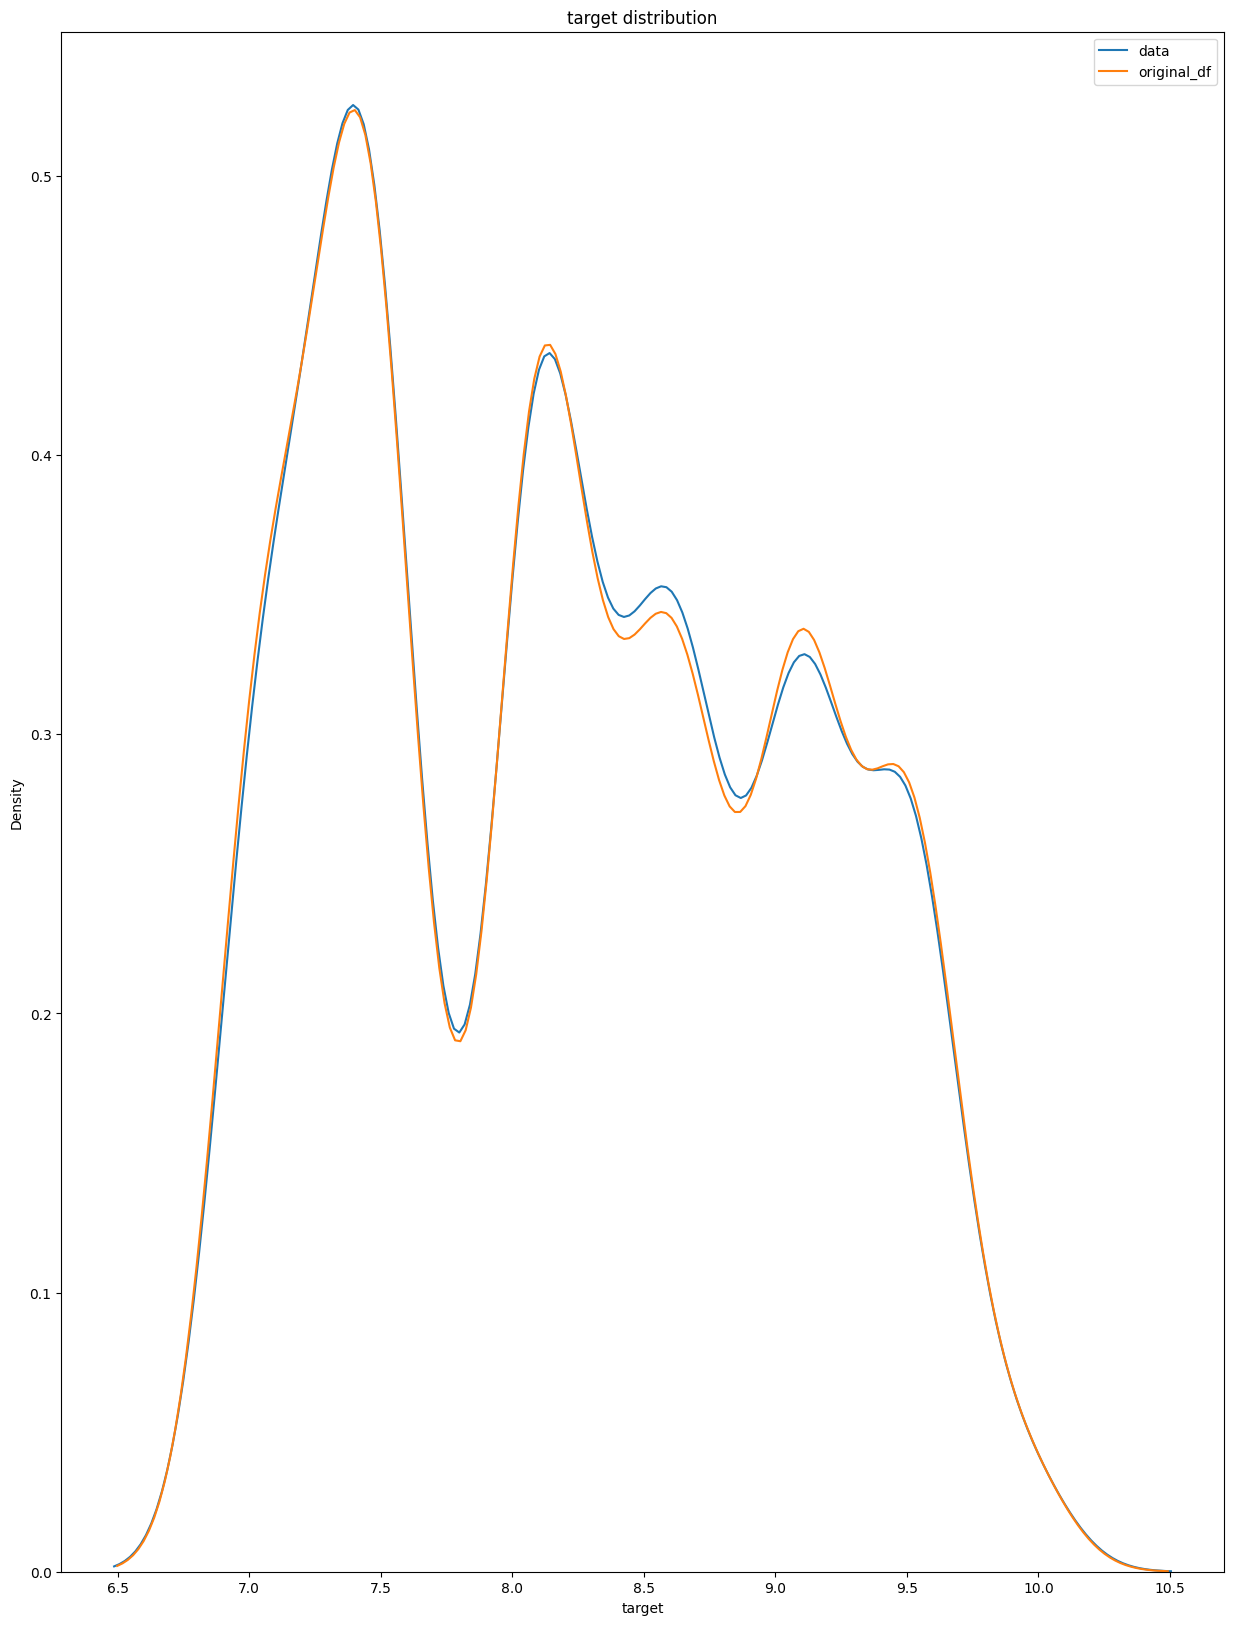

In [86]:
sns.kdeplot(data=sub[sub['target']<10], x="target")
sns.kdeplot(data=data_dropped[data_dropped['target']<10], x="target")
plt.legend(['data','original_df'])
plt.title('target distribution')



In [68]:
submission = data_final.reset_index(drop = True).copy()

submission.head()



,id,target,O2_1,O2_2,O2_3,O2_4,O2_5,O2_6,O2_7,NH4_1,NH4_2,NH4_3,NH4_4,NH4_5,NH4_6,NH4_7,NO2_1,NO2_2,NO2_3,NO2_4,NO2_5,NO2_6,NO2_7,NO3_1,NO3_2,NO3_3,NO3_4,NO3_5,NO3_6,NO3_7,BOD5_1,BOD5_2,BOD5_3,BOD5_4,BOD5_5,BOD5_6,BOD5_7
0,0,8.59,7.500,9.00,0,0,0,0,0,0.180,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,9.10,13.533,40.90,0,0,0,0,0,1.107,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,8.21,3.710,5.42,0,0,0,0,0,0.020,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,8.39,8.700,8.10,0,0,0,0,0,0.280,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,8.07,8.050,8.65,0,0,0,0,0,0.360,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [69]:
submission.shape

(3448, 37)

In [70]:
submission.to_csv('submission.csv', index = False)

In [ ]:
data_final = data_ISO.loc[mask, :].reset_index(drop = True)

X_LOF, Y_LOF = data_final.drop('target', axis = 1), data_final.target

In [81]:
test = sub[sub['target']>7.7]
test = test[test['target']<7.9]

In [83]:
list_id_delete = test.index.to_numpy()
drop_index = np.random.choice(list_id_delete,8,replace=False)

In [84]:
sub = sub.drop(drop_index)

In [85]:
sub.to_csv('submission.csv', index = False)